Team 14 Project:
Machine Learning Model to Identify Ransomware Payment within Bitcoin Transaction

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.mllib.stat import Statistics
from statistics import mode

from pyspark.ml.feature import StandardScaler,StringIndexer,VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

In [0]:
df = spark.read.csv("/mnt/team14/data/BitcoinHeistData.csv",inferSchema=True,header=True)
df.cache()

Out[2]: DataFrame[address: string, year: int, day: int, length: int, weight: double, count: int, looped: int, neighbors: int, income: double, label: string]

In [0]:
print(df.count(),len(df.columns))

2916697 10


In [0]:
df.show(5)

+--------------------+----+---+------+-------------------+-----+------+---------+--------+---------------+
|             address|year|day|length|             weight|count|looped|neighbors|  income|          label|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+---------------+
|111K8kZAEnJg245r2...|2017| 11|    18|0.00833333333333333|    1|     0|        2|1.0005E8|princetonCerber|
|1123pJv8jzeFQaCV4...|2016|132|    44|      2.44140625E-4|    1|     0|        1|   1.0E8| princetonLocky|
|112536im7hy6wtKbp...|2016|246|     0|                1.0|    1|     0|        2|   2.0E8|princetonCerber|
|1126eDRw2wqSkWosj...|2016|322|    72|         0.00390625|    1|     0|        2|  7.12E7|princetonCerber|
|1129TSjKtx65E35Gi...|2016|238|   144| 0.0728484071989931|  456|     0|        1|   2.0E8| princetonLocky|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+---------------+
only showing top 5 rows



In [0]:
distinct_labels = ['padua','montreal','princeton','white']
for i in range(len(distinct_labels)):
  df = df.withColumn("label", F.when(F.col("label").startswith(distinct_labels[i]),distinct_labels[i]).otherwise(F.col("label")))

In [0]:
df.select("label").distinct().show()

+---------+
|    label|
+---------+
|    white|
|princeton|
|    padua|
| montreal|
+---------+



#EDA

In [0]:
display(df.groupBy('label').count())

label,count
white,2875284
princeton,15848
padua,12402
montreal,13163


Databricks visualization. Run in Databricks to view.

In [0]:
#Checking for missing values
missing_value = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_value.show()

+-------+----+---+------+------+-----+------+---------+------+-----+
|address|year|day|length|weight|count|looped|neighbors|income|label|
+-------+----+---+------+------+-----+------+---------+------+-----+
|      0|   0|  0|     0|     0|    0|     0|        0|     0|    0|
+-------+----+---+------+------+-----+------+---------+------+-----+



No missing values hence we do not need to do data interpolation

In [0]:
df.toPandas().duplicated().sum()

Out[12]: 0

as the returned count is zero, it is safe to say our dataset only have distinct rows

In [0]:
df.printSchema()

root
 |-- address: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- count: integer (nullable = true)
 |-- looped: integer (nullable = true)
 |-- neighbors: integer (nullable = true)
 |-- income: double (nullable = true)
 |-- label: string (nullable = true)



By checking the schema of this dataset, we can see that except address every feature is numeric so we can exclude address from our model as it is not relevant to the case and can't be label encoded to be feeded to the model either.
We also notice that our dataset is made up of continous data.

In [0]:
df.summary().show()

+-------+--------------------+------------------+------------------+-----------------+--------------------+------------------+------------------+------------------+--------------------+--------+
|summary|             address|              year|               day|           length|              weight|             count|            looped|         neighbors|              income|   label|
+-------+--------------------+------------------+------------------+-----------------+--------------------+------------------+------------------+------------------+--------------------+--------+
|  count|             2916697|           2916697|           2916697|          2916697|             2916697|           2916697|           2916697|           2916697|             2916697| 2916697|
|   mean|                null| 2014.475011288454|  181.457211016434|45.00859293920486|  0.5455192341639862| 721.6446428957139|238.50669884461772| 2.206516137946451| 4.464889007186172E9|    null|
| stddev|                

We can see the variation in feature's ranges by looking at their min-max but visualising it using boxplot gives a better overview while making it easier to read it.

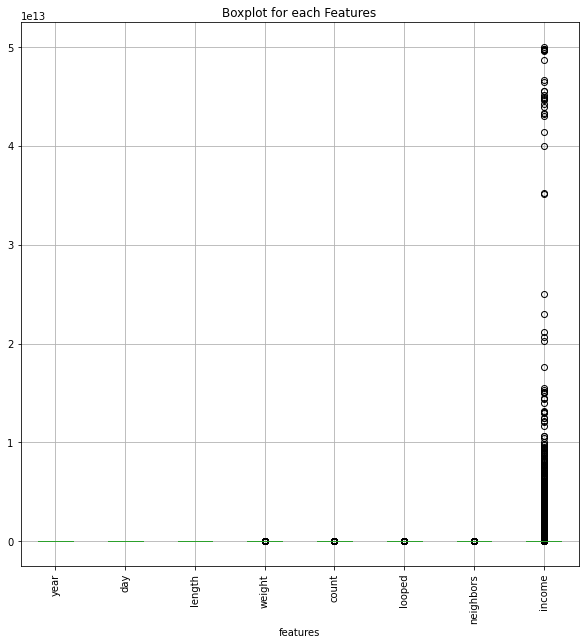

In [0]:
df.toPandas().boxplot(rot=90, figsize=(10,10))
plt.title('Boxplot for each Features')
#plt.suptitle('')
plt.xlabel('features')
plt.show()

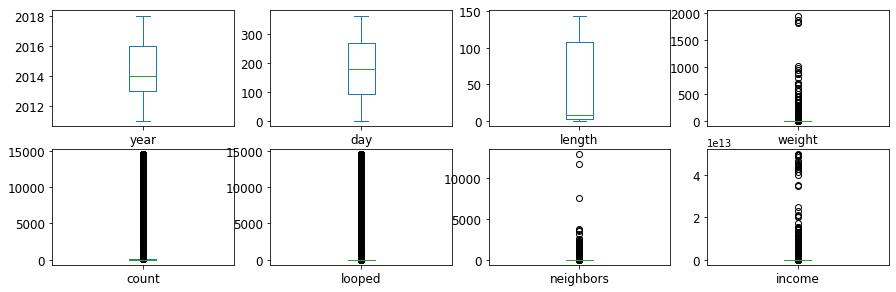

In [0]:
data_mean = df.toPandas().iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False, sharey=False, fontsize=12, figsize=(15,20));

Looking at the box plot, it can be concluded that the dataset is ridden with lots of outliers and the range of features varies in a huge scale which might result in the ML model having trouble in learning features representing this dataset correctly so we will *"scale"* the dataset and deal with outliers

Out[9]: <AxesSubplot:>

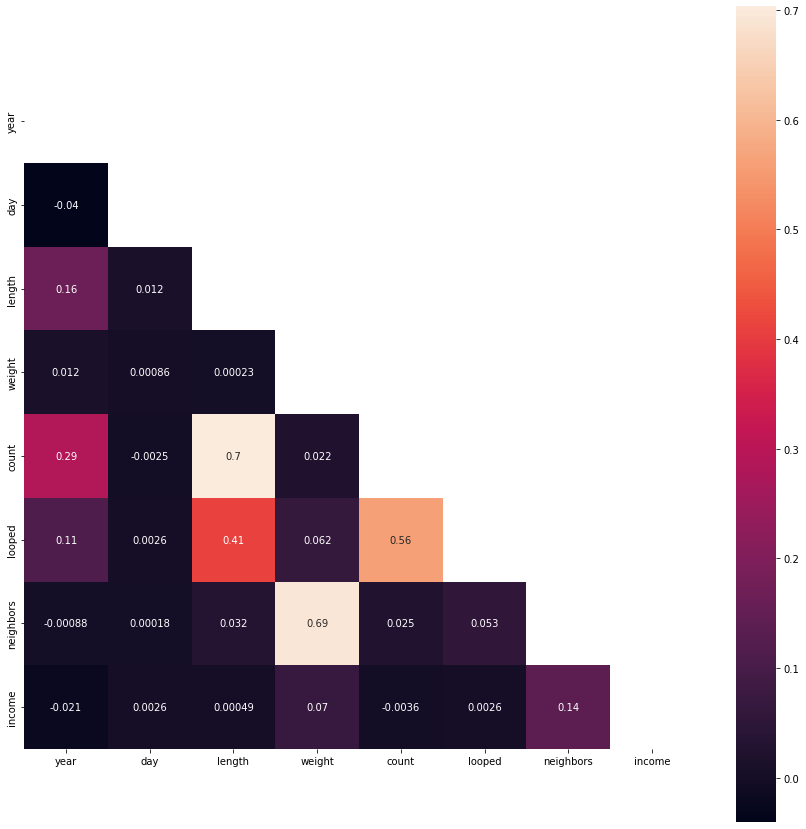

In [0]:
features = df.rdd.map(lambda row: row[1:-1])
corr_mat=Statistics.corr(features, method="pearson")
matrix = np.triu(corr_mat)
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr_mat, annot=True, xticklabels=df.columns[1:-1], yticklabels=df.columns[1:-1], square=True, mask=matrix)

We can see that count is fairly correlated with length and neighbours with weight. As we can see no feature is highly correlated amongst themselves, we can positively conclude that we dont have redundant features which might be following the same trend strictly or be highly proportional. 

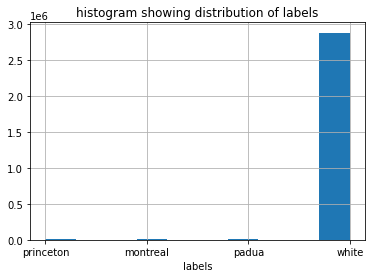

In [0]:
df.toPandas()["label"].hist()
plt.title('histogram showing distribution of labels')
plt.xlabel('labels')
plt.show()

#Pre-Processing

In [0]:
#Removing outliers using z-mean
means = df.select([F.mean(F.col(c)).alias(c) for c in df.columns]).collect()[0].asDict()
std_dev = df.select([F.stddev(F.col(c)).alias(c) for c in df.columns]).collect()[0].asDict()
for column in df.columns[1:-1]:
  cleaned_df = df.filter(F.abs(F.col(column) - means[column]) / std_dev[column] <= 3)
cleaned_df.cache()
df.unpersist()

Out[8]: DataFrame[address: string, year: int, day: int, length: int, weight: double, count: int, looped: int, neighbors: int, income: double, label: string]

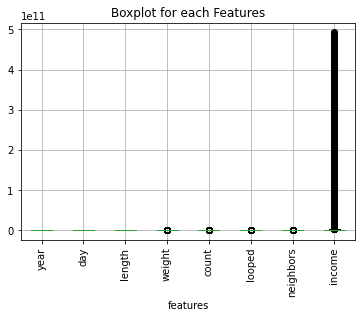

In [0]:
cleaned_df.toPandas().boxplot(rot=90)
plt.title('Boxplot for each Features')
plt.suptitle('')
plt.xlabel('features')
plt.show()

In [0]:
cleaned_df.show(5)

+--------------------+----+---+------+-------------------+-----+------+---------+--------+---------+
|             address|year|day|length|             weight|count|looped|neighbors|  income|    label|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+---------+
|111K8kZAEnJg245r2...|2017| 11|    18|0.00833333333333333|    1|     0|        2|1.0005E8|princeton|
|1123pJv8jzeFQaCV4...|2016|132|    44|      2.44140625E-4|    1|     0|        1|   1.0E8|princeton|
|112536im7hy6wtKbp...|2016|246|     0|                1.0|    1|     0|        2|   2.0E8|princeton|
|1126eDRw2wqSkWosj...|2016|322|    72|         0.00390625|    1|     0|        2|  7.12E7|princeton|
|1129TSjKtx65E35Gi...|2016|238|   144| 0.0728484071989931|  456|     0|        1|   2.0E8|princeton|
+--------------------+----+---+------+-------------------+-----+------+---------+--------+---------+
only showing top 5 rows



In [0]:
display(cleaned_df.groupBy('label').count())

label,count
white,2872441
princeton,15848
padua,12402
montreal,13162


#Decision Tree without Oversample

In [0]:
def savePipeline(pipeline,name):
  basePath = "/mnt/team14/"
  pipeline.save(basePath + name)

In [0]:
feature_cols = cleaned_df.columns[1:]
feature_cols.remove('label')
train,test = cleaned_df.randomSplit([0.7,0.3],seed=7)
vectorAssembler = VectorAssembler(inputCols=feature_cols,outputCol="vectorised")
standardScaler = StandardScaler(inputCol="vectorised",outputCol="features")
label_stringIdx = StringIndexer(inputCol='label',outputCol='idxLabel')
labelTransformer = label_stringIdx.fit(train)
train = labelTransformer.transform(train)
test = labelTransformer.transform(test)
train.cache()
test.cache()
labelTransformer.labels

Out[9]: ['white', 'princeton', 'montreal', 'padua']

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol='idxLabel',metricName='f1')

In [0]:
dt_noOversample = DecisionTreeClassifier(featuresCol = 'features',labelCol = 'idxLabel')
evaluator.setMetricName('f1')
paramGrid_dt_noOversample = ParamGridBuilder().addGrid(dt_noOversample.maxDepth,[17,20,22])\
                                 .build()
cv_dt_noOversample = CrossValidator(estimator=dt_noOversample,estimatorParamMaps=paramGrid_dt_noOversample,evaluator = evaluator,numFolds=5)
pipeline_dt_noOversample = Pipeline(stages=[vectorAssembler,standardScaler,cv_dt_noOversample])
pipeline_dtModel_noOversample = pipeline_dt_noOversample.fit(train)
# pipeline_dtModel_noOversample = PipelineModel.load("/mnt/team14/MulticlassModel-FinalDTwithoutOversample")

In [0]:
prediction = pipeline_dtModel_noOversample.transform(test)
evaluator.setMetricName('f1')
f1_score = evaluator.evaluate(prediction)
evaluator.setMetricName('accuracy')
print(f'True positive rate for White: {evaluator.evaluate(prediction, {evaluator.metricName: "truePositiveRateByLabel",evaluator.metricLabel: 0.0})}')
print(f'True positive rate for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "truePositiveRateByLabel",evaluator.metricLabel: 1.0})}')
print(f'True positive rate for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "truePositiveRateByLabel",evaluator.metricLabel: 2.0})}')
print(f'True positive rate for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "truePositiveRateByLabel",evaluator.metricLabel: 3.0})}')
accuracy = evaluator.evaluate(prediction)
print(f'Accuracy: {accuracy*100}')
train.unpersist()
test.unpersist()

True positive rate for White: 0.9980142634147474
True positive rate for Princeton: 0.3248175182481752
True positive rate for Montreal: 0.23675702561551853
True positive rate for Padua: 0.1956639566395664
Accuracy: 98.75368129114636
Out[13]: DataFrame[address: string, year: int, day: int, length: int, weight: double, count: int, looped: int, neighbors: int, income: double, label: string, idxLabel: double]

As we know the dataset was highly imbalanced where only one class (white) was taking 98.6% of the dataste and the remaining 3 classes only took 1.4% it is safe to say that obtaining high accuracy is very easy as if our model ends up classifying every datapoint as white class, it will still achieve an accuracy of 98.6%. To further prove that, we calculated true positive rate class-wise and every class besides white performed poorly even though the overall accuracy is very high. Hence we should deal with this dataset imbalance by smote-enn and then use suitable evaluation measures on it

In [0]:
savePipeline(pipeline_dtModel_noOversample,"MulticlassModel-FinalDTwithoutOversample")

##Over-sampling (SMOTE-ENN)
###Using Pandas and Sci-kit learn library

In [0]:
# https://towardsdatascience.com/building-an-ml-application-with-mllib-in-pyspark-part-1-ac13f01606e2
data_cols = cleaned_df.columns[:-1]
X = cleaned_df.toPandas().filter(items = data_cols)
Y = cleaned_df.select('label').toPandas()
cleaned_df.unpersist()
X.shape, Y.shape

In [0]:
overSampler = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='all'))
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=7,stratify=Y)

In [0]:
x_train = x_train.drop('address',axis=1)
x_train_res, y_train_res = overSampler.fit_resample(x_train,y_train)

In [0]:
y_train_res.value_counts()

In [0]:
dataframe1 = pd.DataFrame(x_train_res,columns=data_cols)
dataframe2 = pd.DataFrame(y_train_res,columns=['label'])

In [0]:
x_train = dataframe1.reset_index()
y_train = dataframe2.reset_index()
x_test = x_test.reset_index()
y_test = y_test.reset_index()

In [0]:
train = pd.concat([x_train,y_train],axis=1)
test = pd.concat([x_test,y_test],axis=1)
train = train.drop(train.columns[:1],axis=1)
test = test.drop(test.columns[:1],axis=1)

In [0]:
train_df=spark.createDataFrame(train) 
test_df = spark.createDataFrame(test)

In [0]:
train_df.write.format("csv").save("/mnt/team14/data/train_data")
test_df.write.format("csv").save("/mnt/team14/data/test_data")

#Train Test Loading

In [0]:
train_df = spark.read.csv("/mnt/team14/data/train_data",inferSchema=True)
test_df = spark.read.csv("/mnt/team14/data/test_data",inferSchema=True)
column_name = ['address','year','day','length','weight','count','looped','neighbour','income','label']
train_df = train_df.withColumnRenamed('_c0',column_name[0])\
                   .withColumnRenamed('_c1',column_name[1])\
                   .withColumnRenamed('_c2',column_name[2])\
                   .withColumnRenamed('_c3',column_name[3])\
                   .withColumnRenamed('_c4',column_name[4])\
                   .withColumnRenamed('_c5',column_name[5])\
                   .withColumnRenamed('_c6',column_name[6])\
                   .withColumnRenamed('_c7',column_name[7])\
                   .withColumnRenamed('_c8',column_name[8])\
                   .withColumnRenamed('_c9',column_name[9])
test_df = test_df.withColumnRenamed('_c0',column_name[0])\
                   .withColumnRenamed('_c1',column_name[1])\
                   .withColumnRenamed('_c2',column_name[2])\
                   .withColumnRenamed('_c3',column_name[3])\
                   .withColumnRenamed('_c4',column_name[4])\
                   .withColumnRenamed('_c5',column_name[5])\
                   .withColumnRenamed('_c6',column_name[6])\
                   .withColumnRenamed('_c7',column_name[7])\
                   .withColumnRenamed('_c8',column_name[8])\
                   .withColumnRenamed('_c9',column_name[9])

In [0]:
train_df = train_df.orderBy(F.rand())
test_df = test_df.orderBy(F.rand())
train_df.cache()
test_df.cache()

Out[15]: DataFrame[address: string, year: double, day: double, length: double, weight: double, count: double, looped: double, neighbour: double, income: double, label: string]

# Vector Assembler & Standard Scaler

In [0]:
feature_cols = train_df.columns[1:]
feature_cols.remove('label')
vectorAssembler = VectorAssembler(inputCols=feature_cols,outputCol="vectorised")
standardScaler = StandardScaler(inputCol="vectorised",outputCol="features")
label_stringIdx = StringIndexer(inputCol='label',outputCol='idxLabel')
labelTransformer = label_stringIdx.fit(train_df)
train_df = labelTransformer.transform(train_df)
test_df = labelTransformer.transform(test_df)
labelTransformer.labels

Out[16]: ['princeton', 'padua', 'montreal', 'white']

# Evaluator 

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol='idxLabel',metricName='f1')

# Method to Save pipeline

In [0]:
def savePipeline(pipeline,name):
  basePath = "/mnt/team14/"
  pipeline.save(basePath + name)

#Bagging Method
Obtained from Guest Lecture from Dr Issac Triguero in Week 8


In [0]:
def baggingMethod (train_features, weak_learner,bootstrap_size, maxIter=10):
  models = []
  for i in range(maxIter):
    bag = train_features.sample(withReplacement=True,fraction=bootstrap_size)
    weak_learner.setPredictionCol(f'prediction_{i}')
    weak_learner.setProbabilityCol(f'prob_{i}')
    weak_learner.setRawPredictionCol(f'raw_pred_{i}')
    print(f'Model {i}')
    models.append(weak_learner.fit(bag))
  return models

In [0]:
def test_individual_models(test_features,models):
  evaluator_test = MulticlassClassificationEvaluator(labelCol='idxLabel',metricName='f1')
  for i in range(len(models)):
    prediction = models[i].transform(test_features)
    evaluator_test.setMetricName('f1')
    evaluator_test.setPredictionCol(f'prediction_{i}')
    f1 = evaluator_test.evaluate(prediction)
    evaluator_test.setMetricName('accuracy')
    acc = evaluator_test.evaluate(prediction)
    print(f"F1 Score Model {i} = {f1}")
    print(f"Accuracy Score Model {i} = {acc*100}")

In [0]:
def evaluate_ensemble(model,test_features):
  final_evaluator = MulticlassClassificationEvaluator(predictionCol='pred',labelCol='idxLabel',metricName='f1')
  mode_udf = F.udf(mode,DoubleType())
  prediction = model.transform(test_features)
  ensemble = prediction.select('address',F.array([f'prediction_{i}' for i in range(10)]).alias("prediction"),"idxLabel")
  majority_pred = ensemble.withColumn("pred",mode_udf("prediction"))
  f1score = final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "f1"})
  accuracy = final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "accuracy"})
  print(f'Recall for White: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "recallByLabel",final_evaluator.metricLabel: 3.0})}')
  print(f'Recall for Princeton: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "recallByLabel",final_evaluator.metricLabel: 0.0})}')
  print(f'Recall for Montreal: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "recallByLabel",final_evaluator.metricLabel: 2.0})}')
  print(f'Recall for Padua: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "recallByLabel",final_evaluator.metricLabel: 1.0})}')
  print(f'Precision for White: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "precisionByLabel",final_evaluator.metricLabel: 3.0})}')
  print(f'Precision for Princeton: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "precisionByLabel",final_evaluator.metricLabel: 0.0})}')
  print(f'Precision for Montreal: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "precisionByLabel",final_evaluator.metricLabel: 2.0})}')
  print(f'Precision for Padua: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "precisionByLabel",final_evaluator.metricLabel: 1.0})}')
  print(f'F Measure for White: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "fMeasureByLabel",final_evaluator.metricLabel: 3.0})}')
  print(f'F Measure for Princeton: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "fMeasureByLabel",final_evaluator.metricLabel: 0.0})}')
  print(f'F Measure for Montreal: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "fMeasureByLabel",final_evaluator.metricLabel: 2.0})}')
  print(f'F Measure for Padua: {final_evaluator.evaluate(majority_pred, {final_evaluator.metricName: "fMeasureByLabel",final_evaluator.metricLabel: 1.0})}')
  print(f'Accuracy: {accuracy * 100}')
  print(f'F1 score: {f1score}')

#Bagging with Logistic Regression

In [0]:
scalerTransformer = StandardScaler(inputCol='vectorised',outputCol='features').fit(vectorAssembler.transform(train_df))

In [0]:
Xtrain_bag = scalerTransformer.transform(vectorAssembler.transform(train_df))
lr = LogisticRegression(featuresCol='features',labelCol='idxLabel',family='multinomial')
models = baggingMethod(Xtrain_bag,lr,1.0)

In [0]:
Xtest_bag = scalerTransformer.transform(vectorAssembler.transform(test_df))
pipeline_lrModel = PipelineModel(stages=models)
savePipeline(pipeline_lrModel,"MulticlassModel-FinalELR")
# pipeline_lrModel = PipelineModel.load("/mnt/team14/MulticlassModel-FinalELR")
evaluate_ensemble(pipeline_lrModel,Xtest_bag)

Recall for White: 0.1654876458109946
Recall for Princeton: 0.9760201935212452
Recall for Montreal: 0.5348189415041783
Recall for Padua: 0.7524858908895459
Precision for White: 0.9966175134530715
Precision for Princeton: 0.016593592870476993
Precision for Montreal: 0.008902865188195273
Precision for Padua: 0.013071102127321871
F Measure for White: 0.2838433075708931
F Measure for Princeton: 0.03263239327660173
F Measure for Montreal: 0.017514180515474178
F Measure for Padua: 0.02569585287288812
Accuracy: 17.40627531012771
F1 score: 0.2801751326819395


In [0]:
test_individual_models(Xtest_bag,models)

#Logistic Regression

In [0]:
lrs = LogisticRegression(featuresCol='features',labelCol='idxLabel',family='multinomial')
evaluator.setMetricName('f1')
paramGrid_lrs = ParamGridBuilder().addGrid(lrs.elasticNetParam,[0,0.6,1.0])\
                                 .addGrid(lrs.regParam,[0.01,0.1,1.0])\
                                 .build()
cv_lrs = CrossValidator(estimator=lrs,estimatorParamMaps=paramGrid_lrs,evaluator = evaluator,numFolds=5)
pipeline_lrs = Pipeline(stages=[vectorAssembler,standardScaler,cv_lrs])
pipeline_lrsModel = pipeline_lrs.fit(train_df)
# pipeline_lrsModel = PipelineModel.load("/mnt/team14/MulticlassModel-FinalLRS")

In [0]:
prediction = pipeline_lrsModel.transform(test_df)
evaluator.setMetricName('f1')
f1_score = evaluator.evaluate(prediction)
evaluator.setMetricName('accuracy')
accuracy = evaluator.evaluate(prediction)
print(f'Recall for White: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 3.0})}')
print(f'Recall for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 0.0})}')
print(f'Recall for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 2.0})}')
print(f'Recall for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 1.0})}')
print(f'Precision for White: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 3.0})}')
print(f'Precision for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 0.0})}')
print(f'Precision for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 2.0})}')
print(f'Precision for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 1.0})}')
print(f'F Measure for White: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 3.0})}')
print(f'F Measure for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 0.0})}')
print(f'F Measure for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 2.0})}')
print(f'F Measure for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 1.0})}')
print(f'Accuracy: {accuracy*100}')
print(f'F1 Score: {f1_score}')

Recall for White: 0.12377282032000668
Recall for Princeton: 0.9854859066049643
Recall for Montreal: 0.5340592555077235
Recall for Padua: 0.7683418435904327
Precision for White: 0.9975589225589225
Precision for Princeton: 0.015100189840166827
Precision for Montreal: 0.009222897625399048
Precision for Padua: 0.012522721797595322
F Measure for White: 0.22022150369792248
F Measure for Princeton: 0.029744615335777658
F Measure for Montreal: 0.018132654684269126
F Measure for Padua: 0.024643789920095163
Accuracy: 13.305634234621738
F1 Score: 0.21744016871309615


In [0]:
savePipeline(pipeline_lrsModel,"MulticlassModel-FinalLRS")

# Random Forest

In [0]:
rf = RandomForestClassifier(featuresCol = 'features',labelCol = 'idxLabel')
evaluator.setMetricName('f1')
paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees,[15,17,19])\
                                 .addGrid(rf.maxDepth,[12,15,17])\
                                 .build()
cv_rf = CrossValidator(estimator=rf,estimatorParamMaps=paramGrid_rf,evaluator = evaluator,numFolds=5)
pipeline_rf = Pipeline(stages=[vectorAssembler,standardScaler,cv_rf])
pipeline_rfModel = pipeline_rf.fit(train_df)
# pipeline_rfModel = PipelineModel.load("/mnt/team14/MulticlassModel-FinalRF")

In [0]:
# Evaluating Random Forest
prediction = pipeline_rfModel.transform(test_df)
evaluator.setMetricName('f1')
f1_score = evaluator.evaluate(prediction)
evaluator.setMetricName('accuracy')
accuracy = evaluator.evaluate(prediction)
print(f'Recall for White: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 3.0})}')
print(f'Recall for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 0.0})}')
print(f'Recall for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 2.0})}')
print(f'Recall for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 1.0})}')
print(f'Precision for White: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 3.0})}')
print(f'Precision for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 0.0})}')
print(f'Precision for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 2.0})}')
print(f'Precision for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 1.0})}')
print(f'F Measure for White: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 3.0})}')
print(f'F Measure for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 0.0})}')
print(f'F Measure for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 2.0})}')
print(f'F Measure for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 1.0})}')
print(f'Accuracy: {accuracy*100}')
print(f'F1 Score: {f1_score}')

Recall for White: 0.8818727864347616
Recall for Princeton: 0.9084981068573833
Recall for Montreal: 0.6323119777158774
Recall for Padua: 0.8997581295350712
Precision for White: 0.99739998608776
Precision for Princeton: 0.09616155319054193
Precision for Montreal: 0.06856687810637889
Precision for Padua: 0.10832847990681421
F Measure for White: 0.9360854025895958
F Measure for Princeton: 0.17391479423371187
F Measure for Montreal: 0.12371798047862063
F Measure for Padua: 0.19337511190689347
Accuracy: 88.09663263765277
F1 Score: 0.9251090745501264


In [0]:
savePipeline(pipeline_rfModel,"MulticlassModel-FinalRF")

#Decision Tree


In [0]:
dt = DecisionTreeClassifier(featuresCol = 'features',labelCol = 'idxLabel')
evaluator.setMetricName('f1')
paramGrid_dt = ParamGridBuilder().addGrid(dt.maxDepth,np.arange(1,31,1))\
                                 .addGrid(dt.maxBins,[32,64,128])\
                                 .build()

cv_dt = CrossValidator(estimator=dt,estimatorParamMaps=paramGrid_dt,evaluator = evaluator,numFolds=5)
pipeline_dt = Pipeline(stages=[vectorAssembler,standardScaler,cv_dt])
pipeline_dtModel = pipeline_dt.fit(train_df)
# pipeline_dtModel = PipelineModel.load("/mnt/team14/MulticlassModel-FinalDT")

In [0]:
prediction = pipeline_dtModel.transform(test_df)
evaluator.setMetricName('f1')
f1_score = evaluator.evaluate(prediction)
evaluator.setMetricName('accuracy')
accuracy = evaluator.evaluate(prediction)
print(f'Recall for White: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 3.0})}')
print(f'Recall for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 0.0})}')
print(f'Recall for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 2.0})}')
print(f'Recall for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 1.0})}')
print(f'Precision for White: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 3.0})}')
print(f'Precision for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 0.0})}')
print(f'Precision for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 2.0})}')
print(f'Precision for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 1.0})}')
print(f'F Measure for White: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 3.0})}')
print(f'F Measure for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 0.0})}')
print(f'F Measure for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 2.0})}')
print(f'F Measure for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 1.0})}')
print(f'Accuracy: {accuracy*100}')
print(f'F1 Score: {f1_score}')

Recall for White: 0.9615576536556609
Recall for Princeton: 0.7684055532183425
Recall for Montreal: 0.41808052671562423
Recall for Padua: 0.6025262026337006
Precision for White: 0.9943502621463963
Precision for Princeton: 0.2791532935962097
Precision for Montreal: 0.1194127007088095
Precision for Padua: 0.16093604192089583
F Measure for White: 0.977679058668059
F Measure for Princeton: 0.4095291479820628
F Measure for Montreal: 0.18576652601969057
F Measure for Padua: 0.254022207115341
Accuracy: 95.65237783645024
F1 Score: 0.9679313998846641


In [0]:
prediction = pipeline_dtModel.transform(train_df)
evaluator.setMetricName('f1')
f1_score = evaluator.evaluate(prediction)
evaluator.setMetricName('accuracy')
accuracy = evaluator.evaluate(prediction)
print(f'Recall for White: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 3.0})}')
print(f'Recall for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 0.0})}')
print(f'Recall for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 2.0})}')
print(f'Recall for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "recallByLabel",evaluator.metricLabel: 1.0})}')
print(f'Precision for White: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 3.0})}')
print(f'Precision for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 0.0})}')
print(f'Precision for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 2.0})}')
print(f'Precision for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "precisionByLabel",evaluator.metricLabel: 1.0})}')
print(f'F Measure for White: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 3.0})}')
print(f'F Measure for Princeton: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 0.0})}')
print(f'F Measure for Montreal: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 2.0})}')
print(f'F Measure for Padua: {evaluator.evaluate(prediction, {evaluator.metricName: "fMeasureByLabel",evaluator.metricLabel: 1.0})}')
print(f'Accuracy: {accuracy*100}')
print(f'F1 Score: {f1_score}')

Recall for White: 0.9892076848726683
Recall for Princeton: 0.9995901707660128
Recall for Montreal: 0.9978670114743583
Recall for Padua: 0.9996271087123386
Precision for White: 0.9985925064993849
Precision for Princeton: 0.9983621229596146
Precision for Montreal: 0.9966814403023652
Precision for Padua: 0.9966258897978431
F Measure for White: 0.9938779418303857
F Measure for Princeton: 0.9989757694510457
F Measure for Montreal: 0.99727387353317
F Measure for Padua: 0.998124243199626
Accuracy: 99.7558214708385
F1 Score: 0.9975550194193246


In [0]:
savePipeline(pipeline_dtModel,"MulticlassModel-FinalDT")

java.lang.Exception: Timed out with exception after 1236 attempts
	at com.databricks.backend.daemon.driver.DriverCorral.com$databricks$backend$daemon$driver$DriverCorral$$handleRequest(DriverCorral.scala:536)
	at com.databricks.backend.daemon.driver.DriverCorral$$anonfun$receive$1.applyOrElse(DriverCorral.scala:909)
	at com.databricks.backend.daemon.driver.DriverCorral$$anonfun$receive$1.applyOrElse(DriverCorral.scala:905)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$2(ServerBackend.scala:119)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:146)
	at com.databricks.rpc.ServerBackend$$anonfun$commonReceive$1.applyOrElse(ServerBackend.scala:146)
	at com.databricks.rpc.ServerBackend.$anonfun$internalReceive$1(ServerBackend.scala:116)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:550)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:645)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:666)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:407)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:158)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:405)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:402)
	at com.databricks.rpc.ServerBackend.withAttributionContext(ServerBackend.scala:24)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:450)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:435)
	at com.databricks.rpc.ServerBackend.withAttributionTags(ServerBackend.scala:24)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags(UsageLogging.scala:640)
	at com.databricks.logging.UsageLogging.recordOperationWithResultTags$(UsageLogging.scala:559)
	at com.databricks.rpc.ServerBackend.recordOperationWithResultTags(ServerBackend.scala:24)
	at com.databricks.logging.UsageLogging.recordOperation(UsageLogging.scala:550)
	at com.databricks.logging.UsageLogging.recordOperation$(UsageLogging.scala:520)
	at com.databricks.rpc.ServerBackend.recordOperation(ServerBackend.scala:24)
	at com.databricks.rpc.ServerBackend.internalReceive(ServerBackend.scala:115)
	at com.databricks.rpc.JettyServer$RequestManager.$anonfun$handleRPC$2(JettyServer.scala:958)
	at scala.util.Try$.apply(Try.scala:213)
	at com.databricks.rpc.JettyServer$RequestManager.handleRPC(JettyServer.scala:958)
	at com.databricks.rpc.JettyServer$RequestManager.handleRequestAndRespond(JettyServer.scala:874)
	at com.databricks.rpc.JettyServer$RequestManager.$anonfun$handleHttp$2(JettyServer.scala:503)
	at com.databricks.rpc.JettyServer$RequestManager.$anonfun$handleHttp$2$adapted(JettyServer.scala:478)
	at com.databricks.logging.activity.ActivityContextFactory$.$anonfun$withActivityInternal$3(ActivityContextFactory.scala:387)
	at com.databricks.logging.UsageLogging.$anonfun$withAttributionContext$1(UsageLogging.scala:407)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(AttributionContext.scala:158)
	at com.databricks.logging.UsageLogging.withAttributionContext(UsageLogging.scala:405)
	at com.databricks.logging.UsageLogging.withAttributionContext$(UsageLogging.scala:402)
	at com.databricks.logging.activity.ActivityContextFactory$.withAttributionContext(ActivityContextFactory.scala:53)
	at com.databricks.logging.UsageLogging.withAttributionTags(UsageLogging.scala:450)
	at com.databricks.logging.UsageLogging.withAttributionTags$(UsageLogging.scala:435)
	at com.databricks.logging.activity.ActivityContextFactory$.withAttributionTags(ActivityContextFactory.scala:53)
	at com.databricks.logging.activity.ActivityContextFactory$.withActivityInternal(

In [0]:
cvModel = pipeline_dtModel.stages[-1]
print(cvModel.bestModel.getMaxDepth())
print(cvModel.bestModel.getMaxBins())

#Conclusion

* Task: Identify ransomware payment within bitcoin transaction

1. Through EDA it was identified that this big data was highly imbalanced. Through successful implementation of SMOTE-ENN on the cluster we were able to balance the dataset.
2. After implementation of various ML models on this balanced dataset, we come to the conclusion that decision tree is the best model for making predictions on this dataset which is represented through the comparison between evaluation metrics. Even though random forest produced identical resutls, decision tree being the lighter model saves us computational cost and time while giving similar/slightly better results.

* This project helped us understand how big data works and its pyspark implementation for such complex tasks like machine learning. We learnt how to handle big data stored in cluster and use various libraries in python to build a classifier which not only detects a bitcoin ransomware threat but also identifies its location. Our team is satisfied with the result and highly grateful for this practical learning opportunity.